In [29]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader

In [30]:
#data pre processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081))
])

In [31]:
#load data
train_dataset=datasets.MNIST(root='./data',train = True, download=True, transform=transform)
test_dataset=datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader=DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader=DataLoader(train_dataset, batch_size=128, shuffle=True)

In [32]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        
        self.flatten=nn.Flatten()

        self.layers=nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Linear(256,10)
        )
    def forward(self, x):
        x=self.flatten(x)
        logits=self.layers(x)
        return logits

device="cuda"
model=MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1024, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
epochs=10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()



    print(f"epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

epoch 1/10 - Loss: 0.2453
epoch 2/10 - Loss: 0.1136
epoch 3/10 - Loss: 0.0832
epoch 4/10 - Loss: 0.0693
epoch 5/10 - Loss: 0.0574
epoch 6/10 - Loss: 0.0504
epoch 7/10 - Loss: 0.0436
epoch 8/10 - Loss: 0.0433
epoch 9/10 - Loss: 0.0386
epoch 10/10 - Loss: 0.0305


In [35]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 98.12%


In [36]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                 [-1, 1024]         525,312
              ReLU-6                 [-1, 1024]               0
            Linear-7                  [-1, 256]         262,400
              ReLU-8                  [-1, 256]               0
            Linear-9                   [-1, 10]           2,570
Total params: 1,192,202
Trainable params: 1,192,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 4.55
Estimated Total Size (MB): 4.59
---------------------------------------

In [49]:
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 99.51%


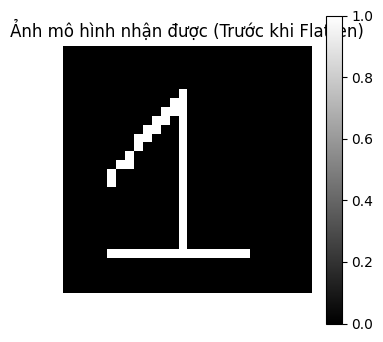

Mô hình dự đoán: 8
Độ tin cậy: 56.76%


In [50]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt # Thêm thư viện hiển thị

def predict_standard_image(image_path, model, device):
    # 1. Mở ảnh và chuyển sang ảnh xám (L)
    img = Image.open(image_path).convert('L')
    
    # 2. Chuyển trực tiếp sang Tensor [0, 1]
    transform = transforms.ToTensor()
    img_tensor = transform(img).unsqueeze(0).to(device) # Shape: [1, 1, 28, 28]
    
    # --- BẮT ĐẦU PHẦN HIỂN THỊ HÌNH ẢNH ---
    # Chuyển tensor về CPU, bỏ các chiều dư thừa (1, 1, 28, 28) -> (28, 28)
    img_show = img_tensor.cpu().squeeze().numpy()
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img_show, cmap='gray')
    plt.title("Ảnh mô hình nhận được (Trước khi Flatten)")
    plt.colorbar() # Hiển thị thang giá trị pixel (từ 0 đến 1)
    plt.axis('off')
    plt.show()
    # --- KẾT THÚC PHẦN HIỂN THỊ ---
    
    # 3. Dự đoán
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        
        prediction = torch.argmax(output, dim=1).item()
        prob = torch.nn.functional.softmax(output, dim=1)
        confidence = prob[0][prediction].item() * 100
        
    return digit, confidence, prob

# Chạy thử (Lưu ý: Thêm dấu nháy kép còn thiếu ở đầu đường dẫn)
path = r"D:\MLP-handwriting\Code\pixilart-drawing (3).png" 

try:
    digit, conf, prob = predict_standard_image(path, model, device)
    print(f"Mô hình dự đoán: {digit}")
    print(f"Độ tin cậy: {conf:.2f}%")
except Exception as e:
    print(f"Lỗi: {e}")

In [52]:
# Giả sử hàm predict_standard_image của bạn trả về: prediction, confidence, prob
# Bạn nên sửa hàm đó để nó trả về cả img_tensor nữa

def predict_standard_image(image_path, model, device):
    img = Image.open(image_path).convert('L')
    transform = transforms.ToTensor()
    # Nếu lúc train có Normalize thì phải thêm vào đây:
    # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        prediction = torch.argmax(output, dim=1).item()
        prob = torch.nn.functional.softmax(output, dim=1)
        confidence = prob[0][prediction].item() * 100
        
    return prediction, confidence, prob, img_tensor # Trả thêm img_tensor ở đây

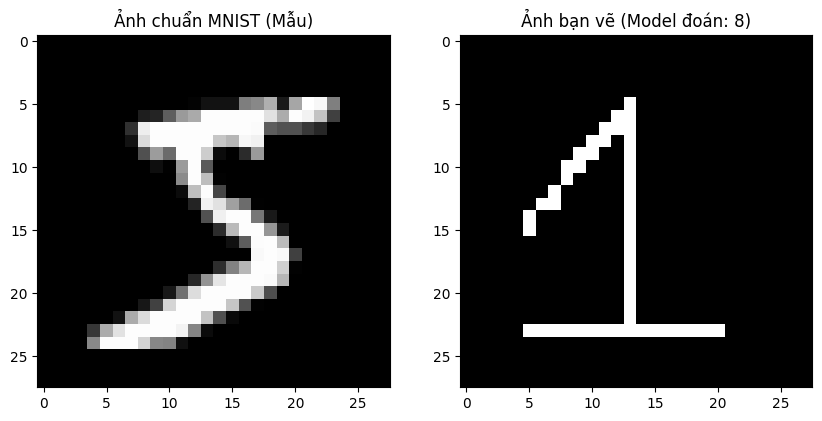

Độ tin cậy: 56.76%


In [53]:
# 1. Chạy dự đoán và hứng lấy img_tensor
path = r"D:\MLP-handwriting\Code\pixilart-drawing (3).png"
digit, conf, prob, current_tensor = predict_standard_image(path, model, device)

# 2. Lấy 1 ảnh mẫu từ bộ test MNIST để đối chiếu
# Lưu ý: train_loader hoặc test_loader phải đã được định nghĩa trước đó
mnist_img, _ = next(iter(test_loader)) 
mnist_sample = mnist_img[0].cpu().squeeze().numpy()

# 3. Lấy ảnh bạn vẽ từ tensor vừa trả về
your_img = current_tensor.cpu().squeeze().numpy()

# 4. Hiển thị so sánh
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mnist_sample, cmap='gray')
axes[0].set_title("Ảnh chuẩn MNIST (Mẫu)")
axes[1].imshow(your_img, cmap='gray')
axes[1].set_title(f"Ảnh bạn vẽ (Model đoán: {digit})")
plt.show()

print(f"Độ tin cậy: {conf:.2f}%")